In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
a = np.array([1, 0, 3, 9])
b = np.zeros((a.size, a.max()+1))
c = np.arange(a.size)
b[c,a] = 1
b


array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [3]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)
print(len(dataset))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8700697.85it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135174.24it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2196419.91it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51134.60it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
60000


In [0]:
def to_onehot(x, num_classes=10):
    #assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))#for checking integer
    #if isinstance(x, int):
    #    c = torch.zeros(1, num_classes).long()
    #    c[0][x] = 1
    #else:
    x = x.cpu()
    c = torch.LongTensor(x.size(0), num_classes)
    c.zero_()
    c.scatter_(1, x, 1) # dim, index, src value
    return c

In [5]:
to_onehot(5)

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.label_emb = nn.Embedding(10, 10) #(vocab_size,vector_size)
        #print( self.label_emb.weight)
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True), # when not active it is 0.2*x (if x < 0)
            nn.Dropout(0.3), # to reduce overfitting
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid() # because discriminator gives us probability which must lie between [0, 1]
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784) #flatten the image
        labels.view(labels.size(0), -1) #10-D vector for the passed label
        x = torch.cat((x, labels.float()), 1) #merging the two inputs to be fed to the Discriminator
        out = self.model(x)
        return out.squeeze()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        #self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        labels.view(labels.size(0), -1)
        x = torch.cat((z, labels.float()), 1)
        out = self.model(x)
        return out.view(x.size(0), 1, 28, 28)

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, labels):
    g_optimizer.zero_grad() #intialize the gradient to zero after each iteration/updation
    z = Variable(torch.randn(batch_size, 100)).cuda() #noise vector
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda() #64 size labels ranging from 0-9
    fake_images = generator(z, labels)
    validity = discriminator(fake_images, labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    #Use for loop to replace step()
    #Or come up with a function to avoid discriminator being trained as well
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()
    #print("Print here...1")
    #print(real_images.shape)
    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    #print("Print here...2")
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda() #64 X 100(noise)
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()#64 rows of labels ranging from 0-9
    fake_images = generator(z, labels) #Generate 64 images for the 64 noise inputs
    #print("Print here...3")
    #print(fake_images.shape)
    fake_validity = discriminator(fake_images.detach(), labels) # 64 * 784, 64
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [0]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).cuda()
        c[:, j] = 1
        z = torch.randn(10, n_noise).cuda()
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

Starting epoch 0...
g_loss: 0.580531895160675, d_loss: 1.5538814067840576


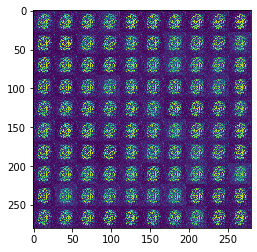

Starting epoch 1...
g_loss: 3.672023296356201, d_loss: 0.43279048800468445


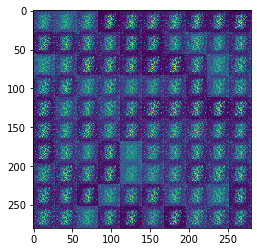

Starting epoch 2...
g_loss: 3.763167381286621, d_loss: 0.3600238561630249


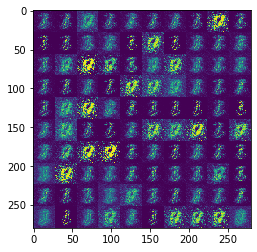

Starting epoch 3...
g_loss: 4.724122524261475, d_loss: 0.3558003902435303


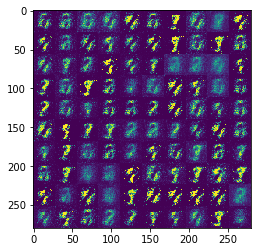

Starting epoch 4...
g_loss: 5.074778079986572, d_loss: 0.16552989184856415


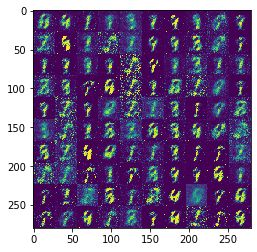

Starting epoch 5...
g_loss: 3.5149776935577393, d_loss: 0.44985586404800415


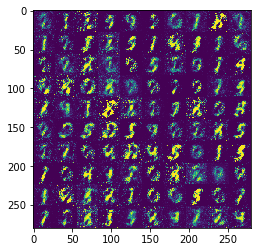

Starting epoch 6...
g_loss: 4.228408336639404, d_loss: 0.4099457263946533


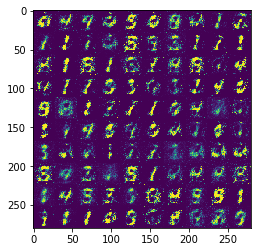

Starting epoch 7...
g_loss: 2.9944214820861816, d_loss: 0.42923566699028015


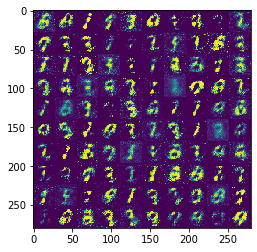

Starting epoch 8...
g_loss: 4.072823524475098, d_loss: 0.350898802280426


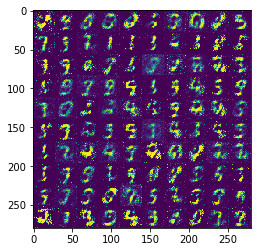

Starting epoch 9...
g_loss: 3.465599298477173, d_loss: 0.6064127683639526


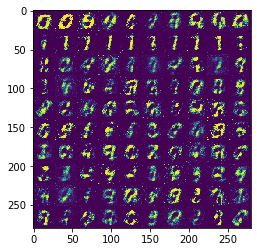

Starting epoch 10...
g_loss: 3.342067241668701, d_loss: 0.7892847061157227


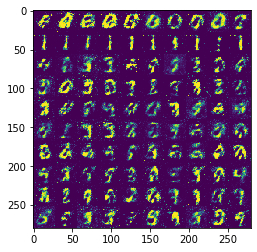

Starting epoch 11...
g_loss: 2.5538532733917236, d_loss: 0.48429185152053833


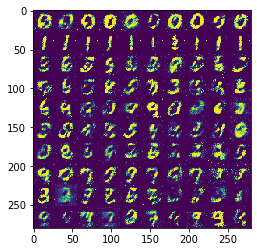

Starting epoch 12...
g_loss: 2.71842622756958, d_loss: 0.5174956917762756


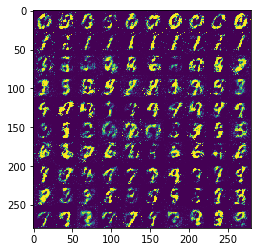

Starting epoch 13...
g_loss: 2.2033143043518066, d_loss: 1.006340503692627


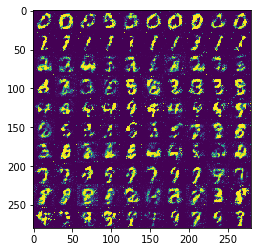

Starting epoch 14...
g_loss: 2.210070848464966, d_loss: 0.5614819526672363


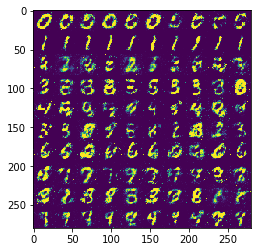

Starting epoch 15...
g_loss: 2.209407329559326, d_loss: 0.771306037902832


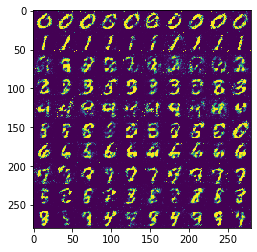

Starting epoch 16...
g_loss: 2.1696434020996094, d_loss: 0.8892907500267029


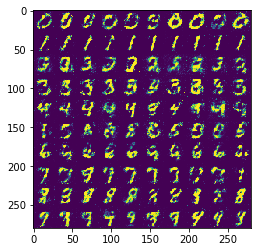

Starting epoch 17...
g_loss: 2.736081838607788, d_loss: 0.8634865880012512


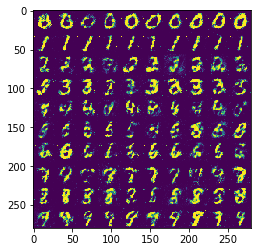

Starting epoch 18...
g_loss: 1.711216926574707, d_loss: 0.8208531141281128


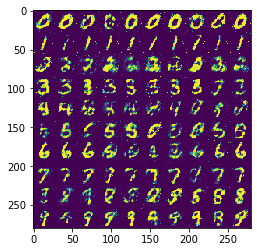

Starting epoch 19...
g_loss: 1.9489339590072632, d_loss: 0.704703688621521


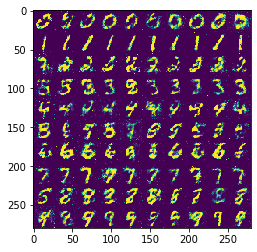

Starting epoch 20...
g_loss: 1.4759860038757324, d_loss: 0.7701898813247681


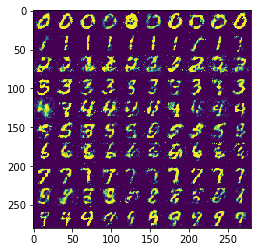

Starting epoch 21...
g_loss: 1.6453089714050293, d_loss: 0.905322790145874


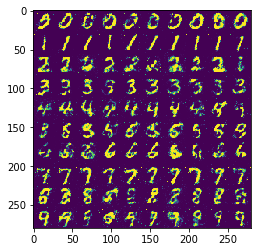

Starting epoch 22...
g_loss: 1.7530481815338135, d_loss: 0.7082424163818359


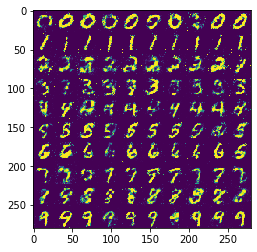

Starting epoch 23...
g_loss: 1.1619701385498047, d_loss: 1.0922133922576904


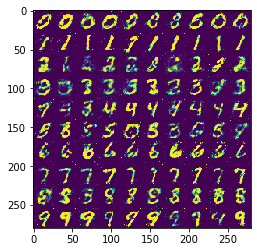

Starting epoch 24...
g_loss: 1.4507657289505005, d_loss: 1.298219919204712


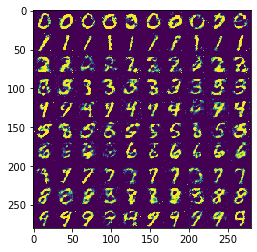

Starting epoch 25...
g_loss: 1.4840192794799805, d_loss: 0.8438572883605957


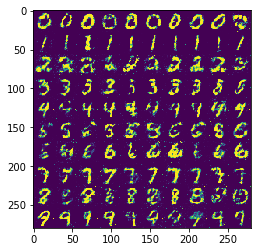

Starting epoch 26...
g_loss: 1.6117662191390991, d_loss: 0.9897294640541077


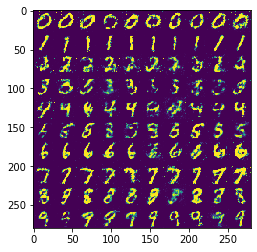

Starting epoch 27...
g_loss: 1.1483633518218994, d_loss: 1.0614619255065918


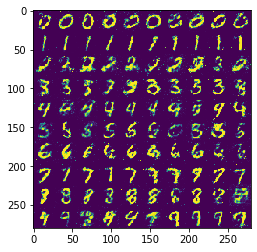

Starting epoch 28...
g_loss: 0.9977061152458191, d_loss: 1.1326854228973389


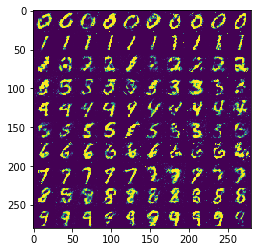

Starting epoch 29...
g_loss: 1.4847266674041748, d_loss: 0.9993412494659424


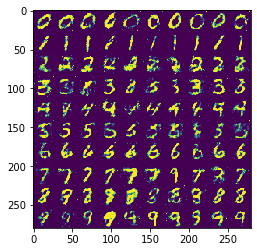

Starting epoch 30...
g_loss: 1.4401342868804932, d_loss: 1.033653974533081


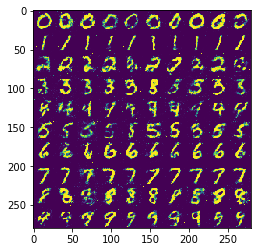

Starting epoch 31...
g_loss: 1.4290459156036377, d_loss: 1.1753822565078735


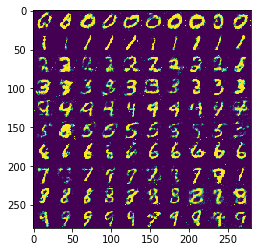

Starting epoch 32...
g_loss: 1.3244909048080444, d_loss: 1.2055776119232178


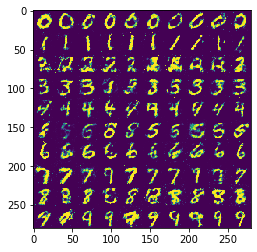

Starting epoch 33...
g_loss: 1.4016642570495605, d_loss: 1.3463551998138428


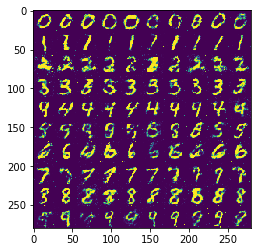

Starting epoch 34...
g_loss: 1.1020585298538208, d_loss: 1.0284086465835571


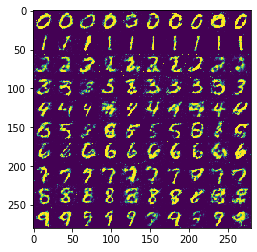

Starting epoch 35...
g_loss: 1.225696086883545, d_loss: 0.9577004909515381


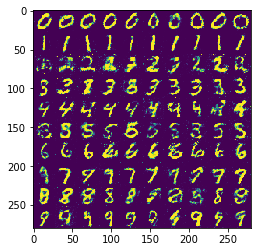

Starting epoch 36...
g_loss: 1.1690828800201416, d_loss: 1.097228765487671


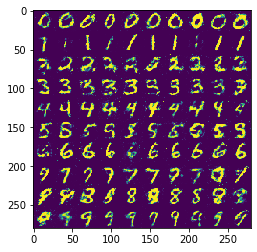

Starting epoch 37...
g_loss: 0.8667821288108826, d_loss: 1.171486496925354


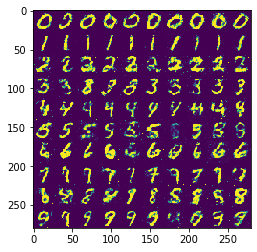

Starting epoch 38...
g_loss: 1.1003998517990112, d_loss: 1.2293846607208252


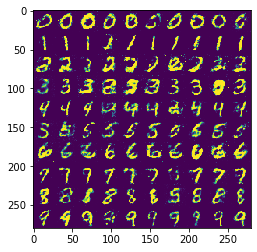

Starting epoch 39...
g_loss: 1.173668622970581, d_loss: 1.0959827899932861


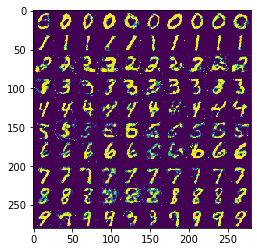

Starting epoch 40...
g_loss: 1.002741813659668, d_loss: 1.0454506874084473


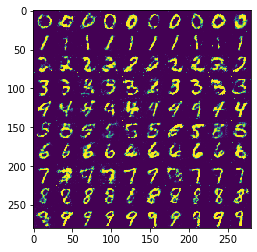

Starting epoch 41...
g_loss: 1.29250168800354, d_loss: 0.9897545576095581


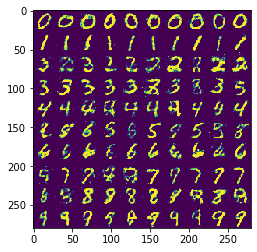

Starting epoch 42...
g_loss: 1.1259818077087402, d_loss: 0.9421902298927307


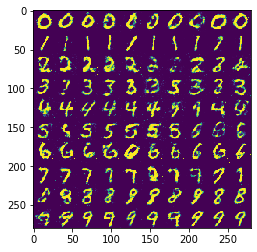

Starting epoch 43...
g_loss: 0.9689614176750183, d_loss: 1.129805564880371


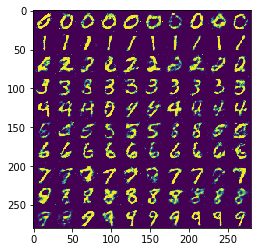

Starting epoch 44...
g_loss: 1.1741347312927246, d_loss: 1.2264620065689087


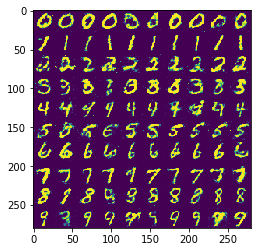

Starting epoch 45...
g_loss: 1.238429069519043, d_loss: 1.205565333366394


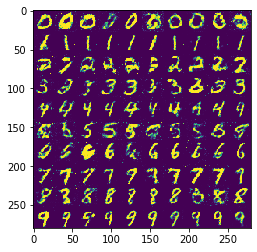

Starting epoch 46...
g_loss: 0.7297735810279846, d_loss: 1.1576083898544312


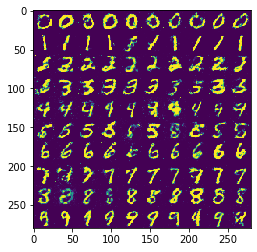

Starting epoch 47...
g_loss: 1.1844794750213623, d_loss: 1.2441225051879883


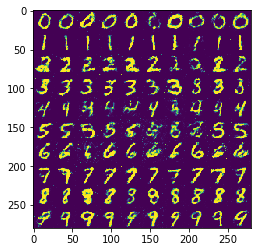

Starting epoch 48...
g_loss: 1.0377089977264404, d_loss: 1.2295477390289307


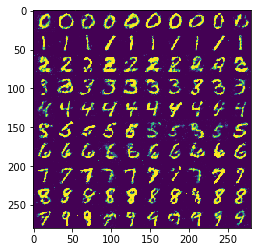

Starting epoch 49...
g_loss: 1.0448639392852783, d_loss: 1.3813538551330566


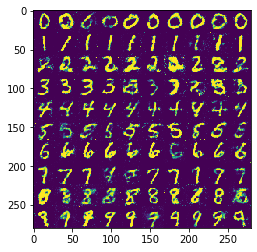

Starting epoch 50...
g_loss: 0.982906699180603, d_loss: 1.1947298049926758


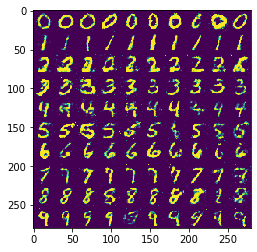

Starting epoch 51...
g_loss: 1.024444580078125, d_loss: 1.029854655265808


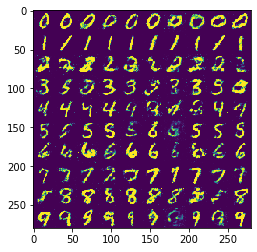

Starting epoch 52...
g_loss: 1.049743890762329, d_loss: 1.0887776613235474


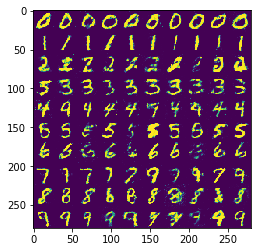

Starting epoch 53...
g_loss: 0.9880794286727905, d_loss: 1.2386162281036377


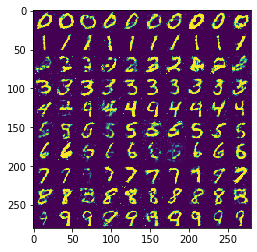

Starting epoch 54...
g_loss: 0.9237927794456482, d_loss: 1.195601463317871


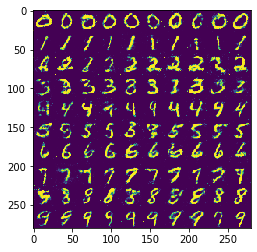

Starting epoch 55...
g_loss: 0.7748377323150635, d_loss: 1.1779829263687134


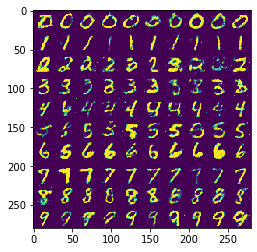

Starting epoch 56...
g_loss: 0.8874862194061279, d_loss: 1.3192861080169678


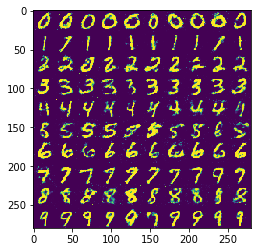

Starting epoch 57...
g_loss: 0.8649294376373291, d_loss: 1.1274125576019287


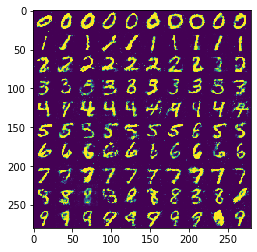

Starting epoch 58...
g_loss: 1.1313536167144775, d_loss: 1.1914137601852417


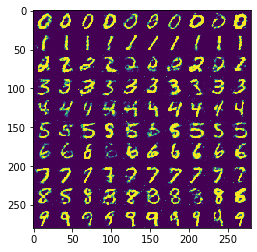

Starting epoch 59...
g_loss: 0.8016367554664612, d_loss: 1.3304848670959473


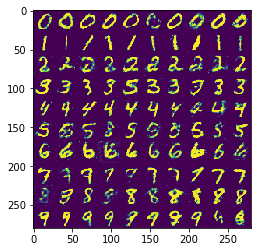

Starting epoch 60...
g_loss: 0.8103398084640503, d_loss: 1.1521351337432861


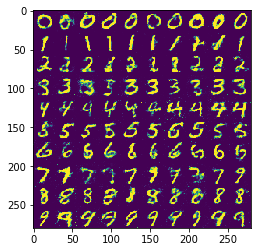

Starting epoch 61...
g_loss: 1.026143193244934, d_loss: 1.3125860691070557


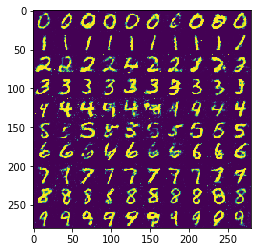

Starting epoch 62...
g_loss: 0.8179091215133667, d_loss: 1.220984697341919


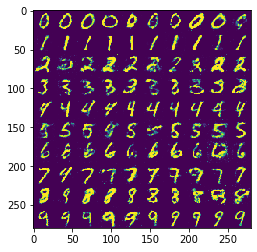

Starting epoch 63...
g_loss: 0.9241163730621338, d_loss: 1.1469759941101074


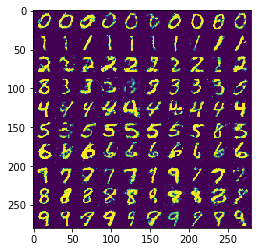

Starting epoch 64...
g_loss: 0.7288445234298706, d_loss: 1.2531296014785767


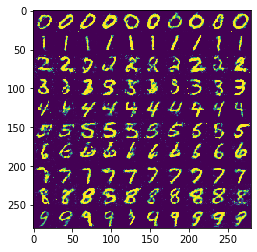

Starting epoch 65...
g_loss: 0.7669879198074341, d_loss: 1.3202731609344482


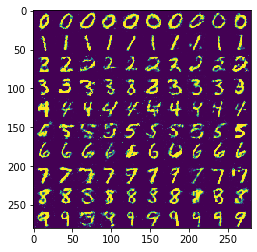

Starting epoch 66...
g_loss: 1.0530822277069092, d_loss: 1.1378345489501953


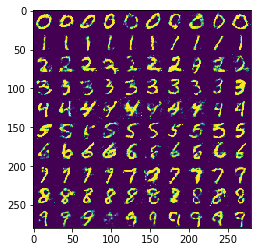

Starting epoch 67...
g_loss: 0.8046947717666626, d_loss: 1.2440608739852905


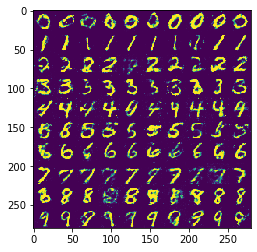

Starting epoch 68...
g_loss: 0.7128828763961792, d_loss: 1.5447450876235962


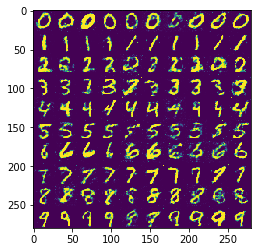

Starting epoch 69...
g_loss: 0.911736249923706, d_loss: 1.3184359073638916


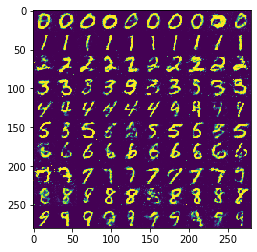

Starting epoch 70...
g_loss: 0.78337562084198, d_loss: 1.368937373161316


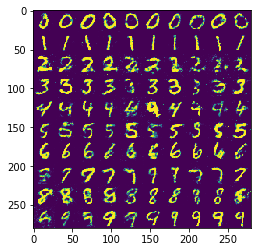

Starting epoch 71...
g_loss: 0.7109892964363098, d_loss: 1.3494195938110352


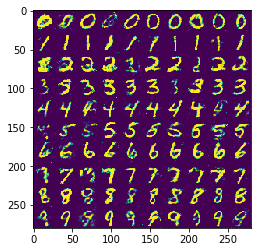

Starting epoch 72...
g_loss: 1.2660470008850098, d_loss: 1.0762200355529785


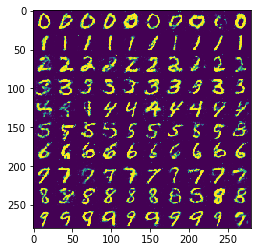

Starting epoch 73...
g_loss: 1.003190517425537, d_loss: 1.017553687095642


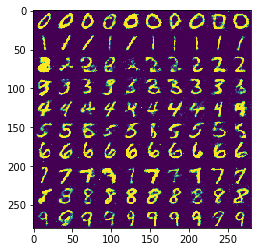

Starting epoch 74...
g_loss: 0.8016257286071777, d_loss: 1.245357632637024


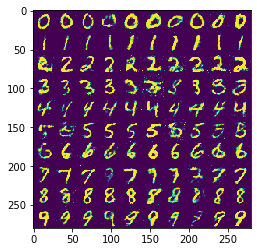

Starting epoch 75...
g_loss: 0.7480206489562988, d_loss: 1.2352216243743896


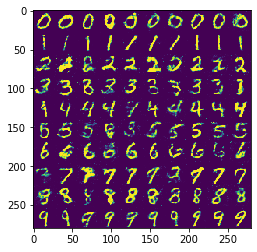

Starting epoch 76...
g_loss: 1.2630870342254639, d_loss: 1.2008626461029053


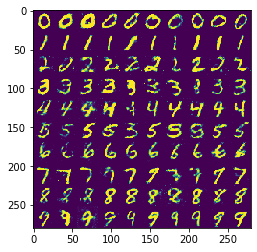

Starting epoch 77...
g_loss: 0.8086943030357361, d_loss: 1.335288643836975


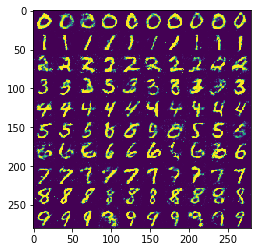

Starting epoch 78...
g_loss: 1.041571021080017, d_loss: 1.2126200199127197


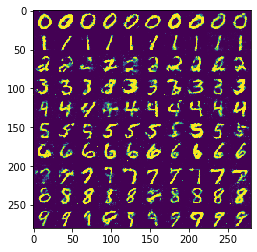

Starting epoch 79...
g_loss: 0.8301379680633545, d_loss: 1.4282037019729614


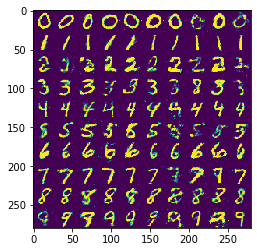

Starting epoch 80...
g_loss: 1.1481530666351318, d_loss: 1.1239185333251953


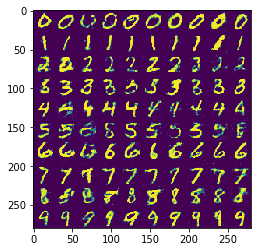

Starting epoch 81...
g_loss: 0.746910572052002, d_loss: 1.426348328590393


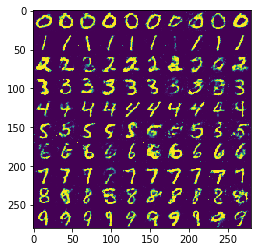

Starting epoch 82...
g_loss: 1.0056204795837402, d_loss: 1.1842007637023926


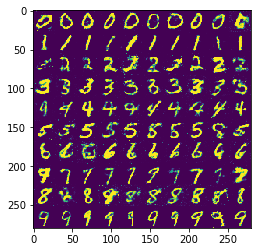

Starting epoch 83...
g_loss: 1.0579681396484375, d_loss: 1.2946834564208984


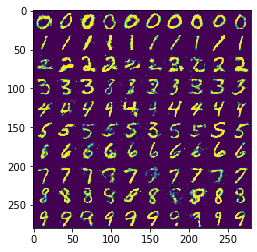

Starting epoch 84...
g_loss: 0.9810631275177002, d_loss: 1.2052159309387207


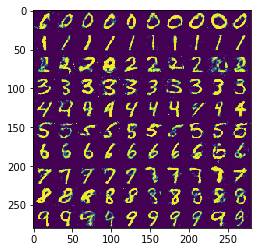

Starting epoch 85...
g_loss: 0.8432048559188843, d_loss: 1.3310539722442627


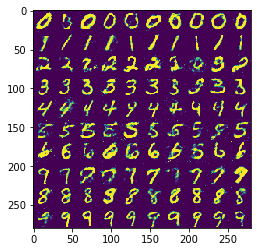

Starting epoch 86...
g_loss: 0.8473130464553833, d_loss: 1.1854009628295898


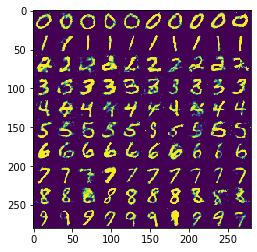

Starting epoch 87...
g_loss: 0.9011203050613403, d_loss: 1.2346553802490234


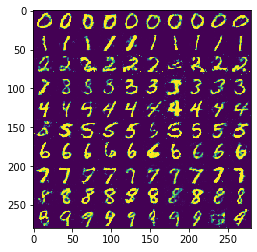

Starting epoch 88...
g_loss: 1.0244486331939697, d_loss: 1.1846296787261963


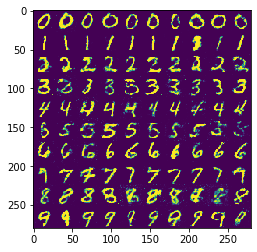

Starting epoch 89...
g_loss: 0.9434933066368103, d_loss: 1.0560688972473145


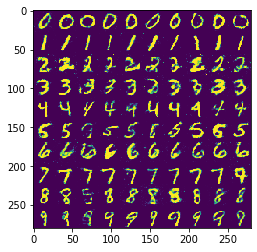

Starting epoch 90...
g_loss: 0.7898670434951782, d_loss: 1.3603438138961792


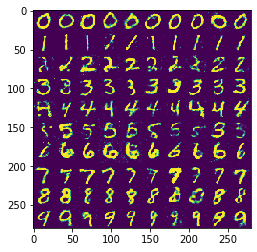

Starting epoch 91...
g_loss: 0.9822665452957153, d_loss: 1.3038718700408936


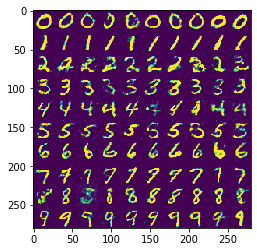

Starting epoch 92...
g_loss: 0.9299594163894653, d_loss: 1.4004130363464355


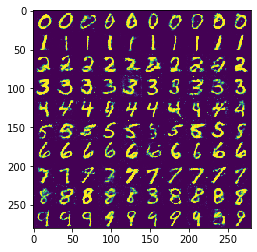

Starting epoch 93...
g_loss: 0.9476919174194336, d_loss: 1.305830717086792


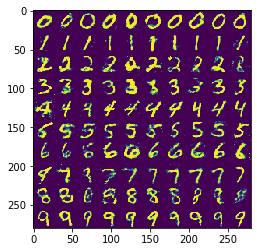

Starting epoch 94...
g_loss: 0.7799675464630127, d_loss: 1.1953423023223877


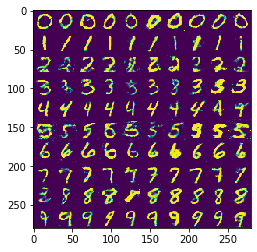

Starting epoch 95...
g_loss: 0.8562453985214233, d_loss: 1.3894717693328857


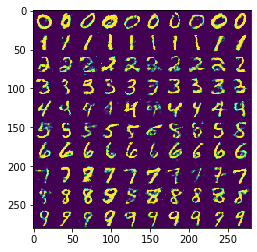

Starting epoch 96...
g_loss: 0.9963579177856445, d_loss: 1.3129054307937622


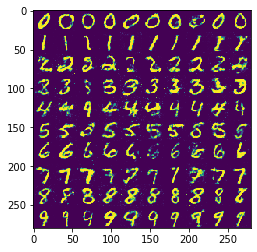

Starting epoch 97...
g_loss: 0.8713608980178833, d_loss: 1.297389030456543


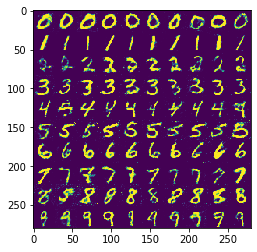

Starting epoch 98...
g_loss: 0.8371121883392334, d_loss: 1.145721673965454


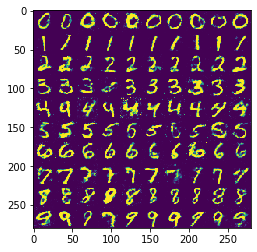

Starting epoch 99...
g_loss: 0.7744253873825073, d_loss: 1.2783889770507812


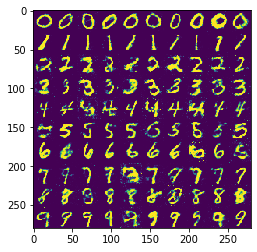

In [13]:
num_epochs = 100
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = images.cuda()
        #labels = labels.cuda()
        generator.train()
        batch_size = real_images.size(0)
        labels = labels.view(batch_size, 1)
        labels = to_onehot(labels).cuda()
        
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion, labels)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    #z = Variable(torch.randn(9, 100)).cuda()
    #labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    #sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    #grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    img = get_sample_image(generator, 100)
    plt.imshow(img)
    plt.show()